evaluate the cut-off of high-weighting genes

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pickle
import numpy as np
import pandas as pd
from pymongo import MongoClient

import seaborn as sns
import matplotlib.pyplot as plt

import smote_variants as sv
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import utils
from sklearn.model_selection import StratifiedShuffleSplit

from utils import *

In [3]:
matfile = '/Users/bogao/DataFiles/new landscape/data/selected_genes_weight.pkl'
labelfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_label.pkl'
dlabelfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_disease_label.pkl'
slabelfile = '/Users/bogao/DataFiles/new landscape/files/all_bands_subtype_label.pkl'
featfile = '/Users/bogao/DataFiles/new landscape/data/selected_gene_mat.pkl'

with open(matfile, 'rb') as fmat, open(labelfile, 'rb') as flab, open(dlabelfile, 'rb') as fdl, open(slabelfile, 'rb') as fsl, open(featfile, 'rb') as ff:
    data = pickle.load(fmat)
    labels = pickle.load(flab)
    disease_labels = pickle.load(fdl)
    subtypes = pickle.load(fsl)
    fm = pickle.load(ff)
    
postive_data = np.maximum(data, 0)


In [24]:
fm = np.array(fm)

## Test distribution of values

### using direct codes

Disease name from codes

In [17]:
data.shape

(42820, 3029)

In [7]:
codes, counts = np.unique(disease_labels, return_counts=True)
df = pd.DataFrame({'code':codes,'count':counts}).sort_values('count', ascending=False)

df = df[(df['count']>50) & (-df['code'].isin(['Others', 'None']))]

disease_names = df.code.tolist()

Check the value distribution of each label

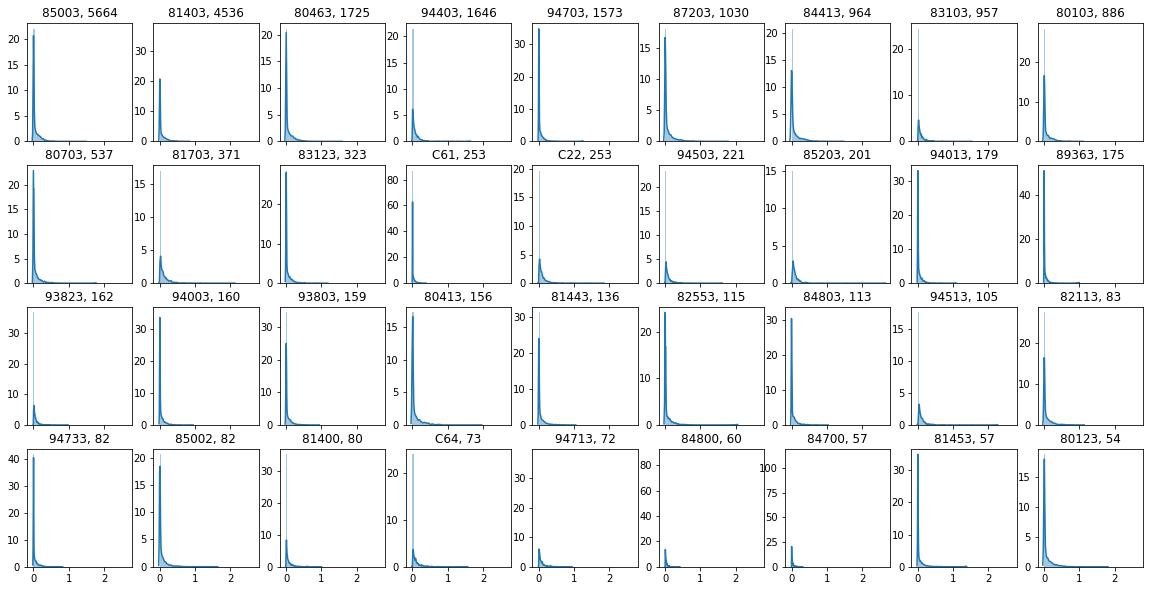

In [10]:
fig, axs = plt.subplots(4, 9, figsize=(20, 10), sharex=True, sharey=False)
r,c = 0, 0
for dname in disease_names:
    disease_data = postive_data[disease_labels == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    
    sns.distplot(sigsum, ax=axs[r, c])
    axs[r, c].set_title('{}, {}'.format(dname, int(df.loc[df.code == dname  , 'count'])))
    if c == 8:
        r += 1
        c = 0
    else:
        c += 1


### Using merged subtype names

Disease names from curation

In [11]:
disease_names = list(np.unique(subtypes['disease']))

disease_names.remove('NA')

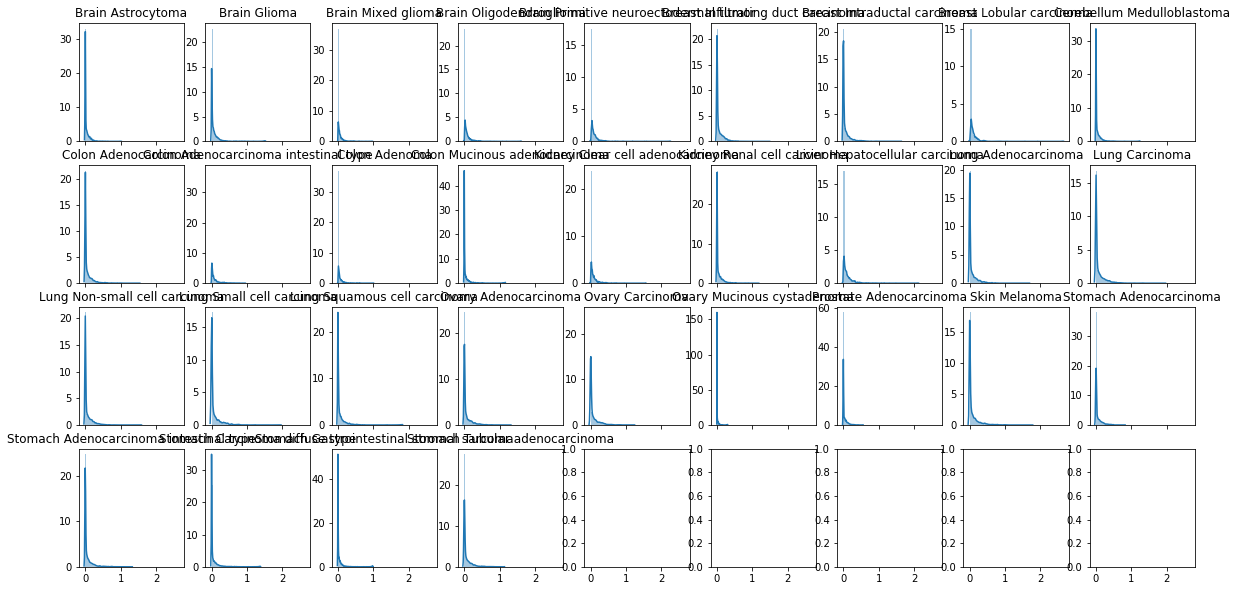

In [12]:
fig, axs = plt.subplots(4, 9, figsize=(20, 10), sharex=True, sharey=False)
r,c = 0, 0
for dname in disease_names:
    disease_data = postive_data[subtypes['disease'] == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    
    sns.distplot(sigsum, ax=axs[r, c])
    axs[r, c].set_title('{}'.format(dname))
    if c == 8:
        r += 1
        c = 0
    else:
        c += 1

## evaluation

In [13]:
disease_names = list(np.unique(subtypes['disease']))
disease_names.remove('NA')

In [14]:
all_results = []
all_high_filters = []

In [ ]:
for sig_thresh in np.arange(0, 0.32, 0.02):

    
    # find high impact bands
    high_impact_genes = [False] * data.shape[1]

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_genes = np.add(high_impact_genes, sigsum>sig_thresh)

    # prepare feature matrix
    names = pd.DataFrame(np.unique(subtypes['disease'], return_counts=True)).transpose()
    names = names.rename(columns={0:'disease',1:'count'})
    names = names[names['disease'] != 'NA']
    names = names.reset_index(drop=True)
    names['target'] = names.index 
    names = names[['disease', 'target']]

    dlt = pd.merge(subtypes, names, how='left', on='disease')

    d = fm[subtypes['disease'] != 'NA'][:,high_impact_genes]
    l = subtypes.loc[subtypes['disease'] != 'NA', 'disease'].to_numpy()
    t = dlt.loc[subtypes['disease'] != 'NA', 'target'].to_numpy().astype(int)
    n = names['disease'].to_numpy()

    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=10)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=10))
    
    all_results.append(result)
    all_high_filters.append(high_impact_genes)

In [29]:
mtr = [[],[],[],[],[]]

for r,f in zip(all_results, all_high_filters):
    r = r[0]
    mtr[0].append(metrics.accuracy_score(r[0], r[1]))
    mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
    mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
    mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
    mtr[4].append(sum(f))

pd.DataFrame({'thresh': np.arange(0, 0.32, 0.02),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.00,0.570436,0.437560,0.450577,0.436140,2905
1,0.02,0.543366,0.409165,0.435614,0.414639,1598
2,0.04,0.559038,0.426085,0.445598,0.427194,1360
3,0.06,0.547996,0.398222,0.427369,0.404853,1224
4,0.08,0.547462,0.433184,0.456915,0.435676,1127
5,0.10,0.558860,0.429321,0.436660,0.424049,1037
6,0.12,0.541763,0.405855,0.415063,0.404777,962
7,0.14,0.541229,0.404518,0.418004,0.403223,892
8,0.16,0.542654,0.407454,0.419255,0.404964,835
9,0.18,0.530365,0.388507,0.419594,0.395524,786


In [30]:
for r, t in zip(all_results, np.arange(0, 0.32, 0.02)):
    
    r = r[0]
    if t == 0:
        classes = evaluate_classes(r, names=dd['name'], sort='Label', ascending=True)
        classes = classes[['Label','F1-score']]
        classes = classes.rename(columns = {'F1-score':str(t)})
    else:
        c = evaluate_classes(r, names=dd['name'], sort='Label', ascending=True)
        c = c[['Label','F1-score']]
        c = c.rename(columns = {'F1-score':str(t)})

        classes = pd.merge(classes, c, how='left', on='Label')

classes


,Label,0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3
0,Brain Astrocytoma,0.243094,0.236559,0.326087,0.240838,0.256158,0.208589,0.282723,0.250000,0.262295,0.238342,0.281250,0.256410,0.301676,0.258824,0.275510,0.262136
1,Brain Glioma,0.704797,0.701181,0.696364,0.690181,0.666667,0.679417,0.686703,0.673267,0.704692,0.693727,0.703499,0.676364,0.680734,0.658737,0.680036,0.670290
2,Brain Mixed glioma,0.170732,0.133333,0.229167,0.164706,0.195122,0.192308,0.252874,0.141176,0.157303,0.219512,0.160000,0.144578,0.229885,0.211538,0.190476,0.161616
3,Brain Oligodendroglioma,0.387097,0.308824,0.310078,0.380282,0.402985,0.411765,0.359375,0.362319,0.464789,0.356589,0.384106,0.429630,0.444444,0.405594,0.428571,0.420290
4,Brain Primitive neuroectodermal tumor,0.372881,0.181818,0.290909,0.202899,0.357143,0.083333,0.230769,0.181818,0.241379,0.185185,0.280702,0.280702,0.222222,0.230769,0.333333,0.400000
5,Breast Infiltrating duct carcinoma,0.531513,0.474429,0.508901,0.465016,0.511135,0.528497,0.481521,0.521081,0.499498,0.461707,0.523549,0.497286,0.490323,0.478166,0.463799,0.534759
6,Breast Intraductal carcinoma,0.734694,0.745098,0.760000,0.577778,0.723404,0.784314,0.693878,0.681818,0.590909,0.625000,0.714286,0.716981,0.576923,0.680000,0.666667,0.666667
7,Breast Lobular carcinoma,0.601399,0.546584,0.613333,0.589744,0.526316,0.601399,0.454545,0.565517,0.454545,0.503145,0.523810,0.509091,0.484848,0.530120,0.481481,0.487805
8,Cerebellum Medulloblastoma,0.703544,0.688869,0.707162,0.685965,0.669611,0.696785,0.683142,0.690817,0.697264,0.687831,0.704645,0.680592,0.684303,0.701322,0.677996,0.653946
9,Colon Adenocarcinoma,0.706458,0.646035,0.690453,0.689060,0.689792,0.708249,0.688363,0.683897,0.681407,0.661323,0.709486,0.719212,0.689585,0.659406,0.643496,0.706237


## prepare labels

In [77]:
names = pd.DataFrame(np.unique(subtypes['disease'], return_counts=True)).transpose()
names = names.rename(columns={0:'disease',1:'count'})
names = names[names['disease'] != 'NA']
names = names.reset_index(drop=True)
names['target'] = names.index 
names = names[['disease', 'target']]

dlt = pd.merge(subtypes, names, how='left', on='disease')

l = subtypes.loc[subtypes['disease'] != 'NA', 'disease'].to_numpy()
t = dlt.loc[subtypes['disease'] != 'NA', 'target'].to_numpy().astype(int)
n = names['disease'].to_numpy()

## grid search

In [32]:
np.arange(0, 0.12, 0.005).shape

(24,)

In [ ]:
all_results_best = []
all_high_filters_best = []

for sig_thresh in np.arange(0, 0.12, 0.005):

    
    # find high impact bands
    high_impact_genes = [False] * data.shape[1]

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_genes = np.add(high_impact_genes, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_genes]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=5, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=18)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=18))

    all_results_best.append(result)
    all_high_filters_best.append(high_impact_genes)

In [37]:
mtr = [[],[],[],[],[]]
n = 5
for res,f in zip(all_results_best, all_high_filters_best):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
    
pd.DataFrame({'thresh': np.arange(0, 0.12, 0.005),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.000,0.557150,0.414563,0.437958,0.418815,2905
1,0.005,0.549849,0.412548,0.436425,0.416599,2159
2,0.010,0.548887,0.409729,0.429571,0.412096,1855
3,0.015,0.552983,0.413863,0.433448,0.416069,1705
4,0.020,0.550419,0.414427,0.442464,0.420435,1598
5,0.025,0.550917,0.413256,0.433663,0.415992,1511
6,0.030,0.544898,0.409166,0.426378,0.410167,1442
7,0.035,0.551095,0.417983,0.435126,0.419003,1390
8,0.040,0.547569,0.412869,0.431834,0.414594,1360
9,0.045,0.547605,0.417564,0.433602,0.417247,1317


In [39]:
mtr = [[],[],[],[],[]]

f = all_high_filters_best[23]
for r in all_results_best[23]:
#     r = r[0]
    mtr[0].append(metrics.accuracy_score(r[0], r[1]))
    mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
    mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
    mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
    mtr[4].append(sum(f))

pd.DataFrame({'thresh': np.arange(0, 5, 1),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0,0.549955,0.422282,0.438662,0.422570,977
1,1,0.545503,0.423311,0.437994,0.424084,977
2,2,0.547462,0.412917,0.435706,0.415236,977
3,3,0.559038,0.414283,0.433696,0.416001,977
4,4,0.559394,0.421106,0.444644,0.423993,977


It seems performance does not drop with increasing thresh, use wider steps to search for higher cut off

## alternative

In [41]:
len(np.arange(0.12, 0.52, 0.02))

20

In [ ]:
all_results_n = []
all_high_filters_n = []

for sig_thresh in np.arange(0.12, 0.52, 0.02):

    
    # find high impact bands
    high_impact_bands = [False] * data.shape[1]

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_bands]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=5, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=18)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=18))

    all_results_n.append(result)
    all_high_filters_n.append(high_impact_bands)

In [43]:
mtr = [[],[],[],[],[]]
n = 5
for res,f in zip(all_results_n, all_high_filters_n):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
  
pd.DataFrame({'thresh': np.arange(0.12, 0.52, 0.02),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})
    


,thresh,accuracy,precision,recall,f1,features
0,0.12,0.550525,0.415383,0.442668,0.420047,962
1,0.14,0.547070,0.406540,0.422929,0.407002,892
2,0.16,0.543651,0.402287,0.425344,0.404892,835
3,0.18,0.544577,0.405325,0.424772,0.406021,786
4,0.20,0.538557,0.395539,0.424015,0.401351,742
5,0.22,0.543865,0.405476,0.432178,0.411030,688
6,0.24,0.538308,0.400733,0.426558,0.404976,635
7,0.26,0.535494,0.396245,0.421679,0.400444,593
8,0.28,0.535067,0.396804,0.419848,0.400264,555
9,0.30,0.533108,0.393367,0.418392,0.397147,528


## alternative grid

In [46]:
len(np.arange(0.11, 0.14, 0.0025))

13

In [ ]:
all_results_grid2 = []
all_high_filters_grid2 = []

for sig_thresh in np.arange(0.11, 0.14, 0.0025):

    
    # find high impact bands
    high_impact_genes = [False] * data.shape[1]

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_genes = np.add(high_impact_genes, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_genes]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=5, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=18)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=18))

    all_results_grid2.append(result)
    all_high_filters_grid2.append(high_impact_genes)

In [48]:
mtr = [[],[],[],[],[]]
n = 5
for res,f in zip(all_results_grid2, all_high_filters_grid2):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
    
pd.DataFrame({'thresh': np.arange(0.11, 0.14, 0.0025),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.1100,0.549991,0.412474,0.433970,0.415630,996
1,0.1125,0.546999,0.408306,0.426122,0.408852,985
2,0.1150,0.546857,0.410846,0.421970,0.409783,977
3,0.1175,0.554550,0.417570,0.435753,0.419419,970
4,0.1200,0.552413,0.421289,0.443911,0.423977,962
5,0.1225,0.555120,0.423248,0.442151,0.424143,948
6,0.1250,0.556296,0.415825,0.437836,0.417977,942
7,0.1275,0.549777,0.420059,0.434509,0.419881,938
8,0.1300,0.552449,0.421270,0.442254,0.424210,927
9,0.1325,0.549207,0.408335,0.429738,0.410767,920


## cut-off conclusion

- 0.13 seems to be the best solution. 

### save the results of 4 expirements to disk

In [49]:
gene_thresh_test = {'results_1fold': all_results,
                    'filters_1fold': all_high_filters,
                    'results_grid1': all_results_best,
                    'filters_grid1': all_high_filters_best,
                    'results_wider': all_results_n,
                    'filters_wider': all_high_filters_n,
                    'results_grid2': all_results_grid2,
                    'filters_grid2': all_high_filters_grid2}

In [50]:
with open('/Users/bogao/DataFiles/new landscape/data/gene_thresh_test.pkl', 'wb') as fo:
    pickle.dump(gene_thresh_test, fo)

## filter gene lists and feature matix

In [52]:
high_impact_genes = all_high_filters_grid2[8]

In [57]:
high_impact_genes.shape

(3029,)

In [64]:
sum(high_impact_genes)

927

In [56]:
high_amp_genes = pd.read_csv('/Users/bogao/DataFiles/Data/genome/high_amp_band_genes.tsv', sep='\t')
high_del_genes = pd.read_csv('/Users/bogao/DataFiles/Data/genome/high_del_band_genes.tsv', sep='\t')

print(high_amp_genes.shape)
print(high_del_genes.shape)

(2294, 7)
(735, 7)


In [58]:
amp_filter = high_impact_genes[:2294]
del_filter = high_impact_genes[2294:]

print(len(amp_filter))
print(len(del_filter))

2294
735


In [61]:
reduced_amp_genes = high_amp_genes[amp_filter]
reduced_del_genes = high_del_genes[del_filter]

In [63]:
print(reduced_amp_genes.shape)
print(reduced_del_genes.shape)

(750, 7)
(177, 7)


In [65]:
reduced_amp_genes.to_csv('/Users/bogao/DataFiles/Data/genome/reduced_high_amp_genes.tsv', sep='\t', index=0)
reduced_del_genes.to_csv('/Users/bogao/DataFiles/Data/genome/reduced_high_del_genes.tsv', sep='\t', index=0)

In [66]:
fm.shape

(42820, 3029)

In [70]:
reduced_fm = fm[:,high_impact_genes]

In [71]:
with open('/Users/bogao/DataFiles/new landscape/data/reduced_gene_mat.pkl', 'wb') as fo:
    pickle.dump(reduced_fm, fo)

In [78]:
dd = {'data': reduced_fm[subtypes['disease'] != 'NA'], 'label':l, 'target':t, 'name':n }
with open('/Users/bogao/DataFiles/new landscape/data/multiclass_reduced_labels.pkl', 'wb') as fo:
    pickle.dump(dd, fo)

## Tests

In [75]:
reduced_fm[subtypes['disease'] != 'NA'].shape

(22671, 927)

In [79]:
reduced_amp_genes

,gene_id,name,chr,start,end,symbol,band
2,ENSG00000157911,p36.32,1,2403964,2413797,PEX10,1p36.32
6,ENSG00000157873,p36.32,1,2555639,2565382,TNFRSF14,1p36.32
14,ENSG00000158109,p36.32,1,3625015,3630127,TPRG1L,1p36.32
19,ENSG00000130764,p36.32,1,3778559,3796498,LRRC47,1p36.32
21,ENSG00000169598,p36.32,1,3857267,3885429,DFFB,1p36.32
...,...,...,...,...,...,...,...
2285,ENSG00000178026,q11.23,22,24585620,24593208,LRRC75B,22q11.23
2287,ENSG00000184571,q11.23,22,24719034,24774720,PIWIL3,22q11.23
2289,ENSG00000206069,q11.23,22,24934954,24946695,TMEM211,22q11.23
2290,ENSG00000197077,q11.23,22,24952730,25197448,KIAA1671,22q11.23


In [80]:
reduced_del_genes

,gene_id,name,chr,start,end,symbol,band
5,ENSG00000162783,q25.3,1,181088700,181092900,IER5,1q25.3
11,ENSG00000135828,q25.3,1,182573634,182589256,RNASEL,1q25.3
43,ENSG00000163848,q21.2,3,125225561,125375354,ZNF148,3q21.2
45,ENSG00000144909,q21.2,3,125528858,125595497,OSBPL11,3q21.2
49,ENSG00000181804,q24,3,143265222,143848485,SLC9A9,3q24
...,...,...,...,...,...,...,...
727,ENSG00000197841,q13.11,19,34734155,34745378,ZNF181,19q13.11
728,ENSG00000153896,q13.11,19,34758073,34773229,ZNF599,19q13.11
730,ENSG00000180884,q13.11,19,34956354,34964229,ZNF792,19q13.11
731,ENSG00000089351,q13.11,19,34994784,35026471,GRAMD1A,19q13.11


In [81]:
pd.merge(reduced_amp_genes, reduced_del_genes, how='outer', on='gene_id')

,gene_id,name_x,chr_x,start_x,end_x,symbol_x,band_x,name_y,chr_y,start_y,end_y,symbol_y,band_y
0,ENSG00000157911,p36.32,1.0,2403964.0,2413797.0,PEX10,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000157873,p36.32,1.0,2555639.0,2565382.0,TNFRSF14,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000158109,p36.32,1.0,3625015.0,3630127.0,TPRG1L,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000130764,p36.32,1.0,3778559.0,3796498.0,LRRC47,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000169598,p36.32,1.0,3857267.0,3885429.0,DFFB,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,ENSG00000197841,NaN,NaN,NaN,NaN,NaN,NaN,q13.11,19.0,34734155.0,34745378.0,ZNF181,19q13.11
914,ENSG00000153896,NaN,NaN,NaN,NaN,NaN,NaN,q13.11,19.0,34758073.0,34773229.0,ZNF599,19q13.11
915,ENSG00000180884,NaN,NaN,NaN,NaN,NaN,NaN,q13.11,19.0,34956354.0,34964229.0,ZNF792,19q13.11
916,ENSG00000089351,NaN,NaN,NaN,NaN,NaN,NaN,q13.11,19.0,34994784.0,35026471.0,GRAMD1A,19q13.11
